In [1]:
# import
import os, sys, shutil, pickle
import numpy as np
import pandas as pd
import scipy as sp
import nibabel as nib
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
from snaplab_tools.utils import threshold_consistency, normalize_x
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns

## Load data

In [2]:
in_dir = '/mnt/storage_ssd_raid/research_data/HCP_YA/collated_outputs'

atlas = 'Schaefer4007'
if atlas == 'Schaefer4007':
    n_parcels = 400
elif atlas == 'Schaefer2007':
    n_parcels = 200
elif atlas == 'Schaefer1007':
    n_parcels = 100

### Connectome

In [3]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_connectome.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

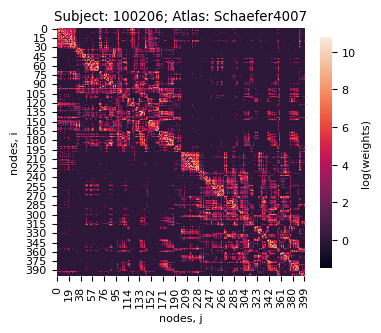

In [4]:
subject_id = '100206'
# atlas = '4S456Parcels'
atlas = 'Schaefer4007'
adjacency = data[subject_id][atlas]
adjacency_log = np.log(adjacency, out=np.zeros_like(adjacency), where=(adjacency != 0))

f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(adjacency_log, ax=ax, square=True, cbar_kws={'shrink': 0.75, 'label': 'log(weights)'})
ax.set_ylabel('nodes, i')
ax.set_xlabel('nodes, j')
ax.set_title('Subject: {0}; Atlas: {1}'.format(subject_id, atlas))
plt.show()

f.savefig('/home/lindenmp/connectome_100206.png', dpi=600, bbox_inches="tight", pad_inches=0.01)


In [5]:
subject_ids = list(data.keys())
n_subs = len(subject_ids)
n_subs

962

In [6]:
subject_filter = np.zeros(n_subs).astype(bool)

In [7]:
parc_dir = '/mnt/storage_ssd_raid/research_data/HCP_YA/derivatives/parcellations'

A = np.zeros((n_parcels, n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        adj = data[subject_ids[i]][atlas].copy()
        
        in_file = os.path.join(parc_dir, '{0}/{0}_atlas-{1}_space-T1w_res-1_regionsizes.txt'.format(subject_ids[i], atlas))
        voxel_counts = np.loadtxt(in_file, dtype=int)
        voxel_counts = normalize_x(voxel_counts) + 1e-5
        size_matrix = np.add.outer(voxel_counts, voxel_counts) / 2
        adj = np.divide(adj, size_matrix)
        adj_mask = adj > 0
        adj[adj_mask] += 1
        adj = np.log(adj, out=np.zeros_like(adj), where=(adj != 0))

        A[:, :, i] = adj
    except:
        subject_filter[i] = True
        
print(np.sum(subject_filter))

0


In [8]:
print(np.any(A < 0))
print(np.any(np.isinf(A)))
print(np.any(np.isnan(A)))

False
False
False


### rest fmri

In [9]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_rsfmri.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [10]:
data['100206']['Schaefer4007'].keys()

dict_keys(['rfMRIREST1LR', 'rfMRIREST1RL', 'rfMRIREST2LR', 'rfMRIREST2RL'])

In [11]:
scans = [
    'rfMRIREST1LR',
    'rfMRIREST2LR',
    'rfMRIREST1RL',
    'rfMRIREST2RL'
    ]

In [12]:
rsts = np.zeros((1200, n_parcels, len(scans), n_subs))

for s, scan in enumerate(scans):
    print(scan)
    for i in tqdm(np.arange(n_subs)):
        try:
            ts = data[subject_ids[i]][atlas][scan].copy()
            
            gs = np.mean(ts, axis=1).reshape(-1, 1)
            gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
            nuis = np.concatenate((gs, gs_diff), axis=1)
            nuis = np.concatenate((nuis, np.square(nuis)), axis=1)

            regr = LinearRegression()
            regr.fit(nuis, ts)
            y_pred = regr.predict(nuis)
            ts = ts - y_pred
            
            # z score
            ts = sp.stats.zscore(ts, axis=0)
            
            if np.any(np.isnan(ts)):
                print('Found NaNs!')
            if np.any(np.isinf(ts)):
                print('Found infs!')

            rsts[:, :, s, i] = ts
        except:
            subject_filter[i] = True
    print(np.sum(subject_filter))

print(np.sum(subject_filter))

rfMRIREST1LR


100%|██████████| 962/962 [00:13<00:00, 69.90it/s]


2
rfMRIREST2LR


100%|██████████| 962/962 [00:13<00:00, 71.10it/s]


8
rfMRIREST1RL


100%|██████████| 962/962 [00:13<00:00, 71.99it/s]


9
rfMRIREST2RL


100%|██████████| 962/962 [00:12<00:00, 75.91it/s]

11
11


### task fmri

In [13]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_tfmri.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [14]:
scans = [
    'tfMRIEMOTIONLR',
    'tfMRIGAMBLINGLR',
    'tfMRILANGUAGELR',
    'tfMRIMOTORLR',
    'tfMRIRELATIONALLR',
    'tfMRISOCIALLR',
    'tfMRIWMLR',
    'tfMRIEMOTIONRL',
    'tfMRIGAMBLINGRL',
    'tfMRILANGUAGERL',
    'tfMRIMOTORRL',
    'tfMRIRELATIONALRL',
    'tfMRISOCIALRL',
    'tfMRIWMRL'
    ]
taskts_dict = dict()

In [15]:
taskts = np.zeros((1, n_parcels, n_subs))

for scan in scans:
    n_trs_task = data[subject_ids[0]][atlas][scan].shape[0]
    print(scan, n_trs_task)
    taskts_tmp = np.zeros((n_trs_task, n_parcels, n_subs))
    for i in tqdm(np.arange(n_subs)):
        try:
            ts = data[subject_ids[i]][atlas][scan].copy()
            
            gs = np.mean(ts, axis=1).reshape(-1, 1)
            gs_diff = np.append(0, np.diff(gs, axis=0)).reshape(-1, 1)
            nuis = np.concatenate((gs, gs_diff), axis=1)
            nuis = np.concatenate((nuis, np.square(nuis)), axis=1)

            regr = LinearRegression()
            regr.fit(nuis, ts)
            y_pred = regr.predict(nuis)
            ts = ts - y_pred
            
            # z score
            ts = sp.stats.zscore(ts, axis=0)
            
            if np.any(np.isnan(ts)):
                print('Found NaNs!')
            if np.any(np.isinf(ts)):
                print('Found infs!')

            taskts_tmp[:, :, i] = ts
        except:
            subject_filter[i] = True
    
    taskts = np.concatenate((taskts, taskts_tmp.copy()), axis=0)
    taskts_dict[scan] = taskts_tmp.copy()
    print(np.sum(subject_filter))

taskts = taskts[1:]
print(np.sum(subject_filter))

tfMRIEMOTIONLR 176


100%|██████████| 962/962 [00:01<00:00, 515.05it/s]


12
tfMRIGAMBLINGLR 253


100%|██████████| 962/962 [00:02<00:00, 371.79it/s]


13
tfMRILANGUAGELR 316


100%|██████████| 962/962 [00:02<00:00, 322.97it/s]


14
tfMRIMOTORLR 284


100%|██████████| 962/962 [00:02<00:00, 367.56it/s]


14
tfMRIRELATIONALLR 232


100%|██████████| 962/962 [00:02<00:00, 431.24it/s]


14
tfMRISOCIALLR 274


100%|██████████| 962/962 [00:02<00:00, 371.02it/s]


14
tfMRIWMLR 405


100%|██████████| 962/962 [00:03<00:00, 256.54it/s]


14
tfMRIEMOTIONRL 176


100%|██████████| 962/962 [00:01<00:00, 526.76it/s]


14
tfMRIGAMBLINGRL 253


100%|██████████| 962/962 [00:02<00:00, 377.26it/s]


15
tfMRILANGUAGERL 316


100%|██████████| 962/962 [00:02<00:00, 327.47it/s]


15
tfMRIMOTORRL 284


100%|██████████| 962/962 [00:02<00:00, 367.60it/s]


15
tfMRIRELATIONALRL 232


100%|██████████| 962/962 [00:02<00:00, 437.71it/s]


15
tfMRISOCIALRL 274


100%|██████████| 962/962 [00:02<00:00, 375.10it/s]


15
tfMRIWMRL 405


100%|██████████| 962/962 [00:03<00:00, 260.08it/s]


15
15


### task fmri contrasts

In [16]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_tfmri_contrasts.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [17]:
# for key in data['100206'][atlas].keys():
#     print(key, data['100206'][atlas][key].keys())

In [18]:
scans = [
    'tfMRIWM',
    'tfMRIEMOTION',
    'tfMRIGAMBLING',
    'tfMRILANGUAGE',
    'tfMRIRELATIONAL',
    'tfMRISOCIAL'
         ]
contrasts = [
    ['0BK', '2BK'],
    ['FACES', 'SHAPES'],
    ['PUNISH', 'REWARD'],
    ['MATH', 'STORY'],
    ['MATCH', 'REL'],
    ['RANDOM', 'TOM']
    ]
taskcon_dict = dict()

In [19]:
for s, scan in enumerate(scans):
    taskcon_tmp = np.zeros((len(contrasts[s]), n_parcels, n_subs))
    for c, contrast in enumerate(contrasts[s]):
        print (s, scan, contrast)
        for i in np.arange(n_subs):
            try:
                con = data[subject_ids[i]][atlas][scan][contrast].copy()
                
                if np.any(np.isnan(con)):
                    print('Found NaNs!')
                if np.any(np.isinf(con)):
                    print('Found infs!')

                taskcon_tmp[c, :, i] = con
            except:
                subject_filter[i] = True
        
    taskcon_dict[scan] = taskcon_tmp.copy()
    
print(np.sum(subject_filter))

0 tfMRIWM 0BK
0 tfMRIWM 2BK
1 tfMRIEMOTION FACES
1 tfMRIEMOTION SHAPES
2 tfMRIGAMBLING PUNISH
2 tfMRIGAMBLING REWARD
3 tfMRILANGUAGE MATH
3 tfMRILANGUAGE STORY
4 tfMRIRELATIONAL MATCH
4 tfMRIRELATIONAL REL
5 tfMRISOCIAL RANDOM
5 tfMRISOCIAL TOM
16


### myelin

In [20]:
# Load data (deserialize)
with open(os.path.join(in_dir, 'hcpya_myelin.pkl'), 'rb') as handle:
    data = pickle.load(handle)

data.keys()

dict_keys(['100206', '100307', '100408', '100610', '101006', '101107', '101309', '101915', '102008', '102109', '102311', '102513', '102614', '102715', '102816', '103111', '103212', '103414', '103515', '103818', '104012', '104416', '104820', '105014', '105115', '105216', '105620', '105923', '106016', '106319', '106521', '106824', '107018', '107321', '107422', '107725', '108020', '108121', '108222', '108323', '108525', '108828', '109123', '109830', '110007', '110411', '110613', '111009', '111211', '111312', '111413', '111514', '111716', '112112', '112314', '112516', '112920', '113215', '113316', '113619', '113922', '114217', '114318', '114419', '114621', '114823', '115017', '115219', '115320', '115724', '115825', '116524', '116726', '117021', '117122', '117324', '117930', '118023', '118124', '118225', '118528', '118730', '118831', '118932', '119025', '119126', '119732', '119833', '120111', '120212', '120414', '120515', '120717', '121416', '121618', '121921', '122317', '122620', '122822',

In [21]:
myelin = np.zeros((n_parcels, n_subs))

for i in np.arange(n_subs):
    try:
        myelin[:, i] = data[subject_ids[i]][atlas]
    except:
        subject_filter[i] = True
        
print(np.sum(subject_filter))

16


## Filter

In [22]:
np.asarray(subject_ids)[subject_filter]

array(['119732', '119833', '136126', '159946', '169747', '183337',
       '202820', '284646', '317332', '329440', '547046', '644246',
       '713239', '751550', '786569', '809252'], dtype='<U6')

In [23]:
A = A[:, :, ~subject_filter]
rsts = rsts[:, :, :, ~subject_filter]
myelin = myelin[:, ~subject_filter]
for scan in taskts_dict.keys():
    taskts_dict[scan] = taskts_dict[scan][:, :, ~subject_filter]
for scan in taskcon_dict.keys():
    taskcon_dict[scan] = taskcon_dict[scan][:, :, ~subject_filter]

try:
    tasksts = taskts[:, :, :, ~subject_filter]

    print(A.shape, rsts.shape, myelin.shape, tasksts.shape)
except:
    print(A.shape, rsts.shape, myelin.shape)

(400, 400, 946) (1200, 400, 4, 946) (400, 946)


In [24]:
try:
    for scan in taskts_dict.keys():
        print(taskts_dict[scan].shape)
        
    for scan in taskcon_dict.keys():
        print(taskcon_dict[scan].shape)
except:
    pass

(176, 400, 946)
(253, 400, 946)
(316, 400, 946)
(284, 400, 946)
(232, 400, 946)
(274, 400, 946)
(405, 400, 946)
(176, 400, 946)
(253, 400, 946)
(316, 400, 946)
(284, 400, 946)
(232, 400, 946)
(274, 400, 946)
(405, 400, 946)
(2, 400, 946)
(2, 400, 946)
(2, 400, 946)
(2, 400, 946)
(2, 400, 946)
(2, 400, 946)


In [25]:
Am = threshold_consistency(A, thr=0.6)
print(Am.shape)

(400, 400)


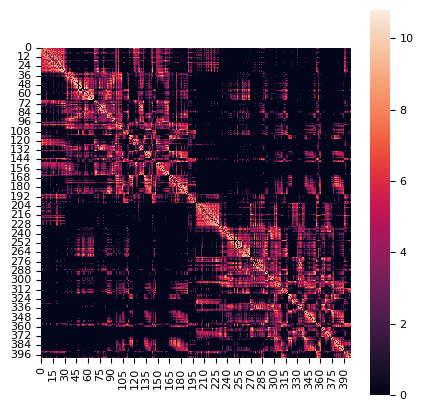

In [26]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(Am, ax=ax, square=True)
plt.show()

In [27]:
np.count_nonzero(np.triu(Am)) / ((Am.shape[0] ** 2 - Am.shape[0]) / 2)

0.3285213032581454

In [28]:
print(np.any(Am < 0))
print(np.any(np.isinf(Am)))
print(np.any(np.isnan(Am)))

False
False
False


## Save

In [29]:
outdir = '/home/lindenmp/research_projects/nct_xr/data/int_deflections'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [30]:
# save
file_str = os.path.join(outdir, 'HCP-YA_{0}_A.npy'.format(atlas))
np.save(file_str, A)
file_str = os.path.join(outdir, 'HCP-YA_{0}_Am.npy'.format(atlas))
np.save(file_str, Am)
file_str = os.path.join(outdir, 'HCP-YA_{0}_myelin.npy'.format(atlas))
np.save(file_str, myelin)
file_str = os.path.join(outdir, 'HCP-YA_{0}_rsts.npy'.format(atlas))
np.save(file_str, rsts)
# file_str = os.path.join(outdir, 'HCP-YA_{0}_taskts.npy'.format(atlas))
# np.save(file_str, taskts)
for scan in taskts_dict.keys():
    file_str = os.path.join(outdir, 'HCP-YA_{0}_taskts-{1}.npy'.format(atlas, scan))
    np.save(file_str, taskts_dict[scan])

In [31]:
file_str = os.path.join(outdir, 'HCP-YA_{0}_subjids.txt'.format(atlas))
subject_ids_filt = np.asarray(subject_ids)[~subject_filter]
np.savetxt(file_str, subject_ids_filt, fmt='%s')

In [32]:
for scan in taskcon_dict.keys():
    file_str = os.path.join(outdir, 'HCP-YA_{0}_taskcon-{1}.npy'.format(atlas, scan))
    np.save(file_str, taskcon_dict[scan])
    
    file_str = os.path.join(outdir, 'HCP-YA_{0}_taskconmean-{1}.npy'.format(atlas, scan))
    np.save(file_str, taskcon_dict[scan].mean(axis=-1))

In [33]:
# taskcon_out = np.zeros((1, n_parcels))  # initialize with a zero state

# for scan in taskcon_dict.keys():
#     taskcon_out = np.concatenate((taskcon_out, taskcon_dict[scan].mean(axis=-1)), axis=0)

# # taskcon_out = taskcon_out[1:]
# print(taskcon_out.shape)

# file_str = os.path.join(outdir, 'HCPYA_{0}_taskconmean.npy'.format(atlas))
# np.save(file_str, taskcon_out)